In [80]:
import numpy as np
from numpy.linalg import inv, pinv, norm
from matplotlib import pyplot as plt

In [81]:
# ns = [int(n) for n in np.logspace(1,3,8)]
n = 100
k = 1
lamda_scale = 2
scale = 1
e1s = np.logspace(-10,10,20)
e2 = 0.1
title_str = f'foward_error_n={n}_k={k}_lambda={lamda_scale}_e2={e2}'
num_experiments = 100

In [82]:
def compute_SMW(n,k,A,B,U,V,lamda,e1,e2,rand_seed=1):
    # np.random.seed(rand_seed)    
    noise1 = np.random.normal(size=(n,n))
    noise1 *= e1/norm(noise1,ord=2)
    noise2 = np.random.normal(size=(k,k))
    noise2 *= e2/norm(noise2,ord=2)

    A_inv = inv(A)
    A_inv_norm = norm(A_inv,ord=2)
    A_til_inv = A_inv + noise1
    Z_inv = inv(np.eye(k)+V.T@A_til_inv@U) + noise2
    B_inv_approx = A_til_inv - A_til_inv@U@Z_inv@V.T@A_til_inv
    B_inv = inv(B) #A_inv - A_inv@U@inv(np.eye(k)+V.T@A_inv@U)@V.T@A_inv
    error = norm(B_inv-B_inv_approx,ord=2)
    bound = 12*e1#e1*((A_inv_norm*lamda)**2+(1+A_inv_norm*lamda)**2)
    B_inv_A_norm = norm(B_inv@A,ord=2)
    # print('B_inv_A_norm = %f'%B_inv_A_norm)
    full_bound = e1 + ((A_inv_norm + e1)**2)*lamda*(e2+2*lamda*B_inv_A_norm**2*e1)+(2*A_inv_norm+e1)*lamda*B_inv_A_norm*e1
    return error,bound,full_bound


In [83]:
errors = np.zeros_like(e1s,dtype=float)
bounds = np.zeros_like(e1s,dtype=float)
full_bounds = np.zeros_like(e1s,dtype=float)
B_inv_A_norms = np.zeros_like(e1s,dtype=float)

A = np.random.normal(size=(n,n),scale= scale)
U = np.random.normal(size=(n,k))
U /= norm(U, ord=2)
V = np.random.normal(size=(n,k))
V /= norm(V, ord=2)
sigma_min = np.min(np.linalg.svd(A,compute_uv=False))
lamda = lamda_scale*sigma_min
B = A + lamda*U@V.T

for i,e1 in enumerate(e1s):
    e_i = np.zeros(num_experiments); b_i = np.zeros(num_experiments); f_i = np.zeros(num_experiments)
    for j in range(num_experiments):
        e_i[j],b_i[j],f_i[j] = compute_SMW(n,k,A,B,np.sqrt(lamda)*U,np.sqrt(lamda)*V,lamda,e1,e2,j)
    errors[i] = np.mean(e_i)
    bounds[i] = np.mean(b_i)
    full_bounds[i] = np.mean(f_i)
    # print("error = %f, bound = %f" %(errors[i],bounds[i]))

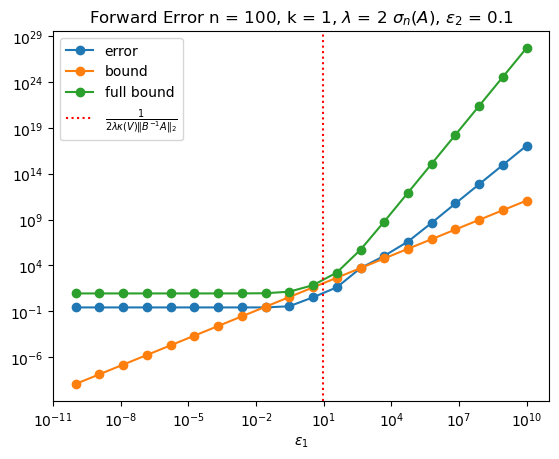

In [84]:
plt.loglog(e1s,errors,label='error',marker='o')
plt.loglog(e1s,bounds,label='bound',marker='o')
plt.loglog(e1s,full_bounds,label='full bound',marker='o')
plt.axvline(x=1/2/lamda/norm(inv(B)@A,ord=2),ls=':',color='red',label=r'$\frac{1}{2\lambda \kappa(V)\|B^{-1}A \|_2}$')
plt.legend()
plt.xlabel(r'$\epsilon_1$')
plt.title(f'Forward Error n = {n}, k = {k}, '+r'$\lambda$'+f' = {lamda_scale} '+r'$\sigma_{n}(A)$'+', '+r'$\epsilon_2$'+f' = {e2}')  #'Approximation Error of '+r'$B^{-1}$'+'(Forward Error n = '+str(n)+ ' )'
plt.savefig('rank1_forward/'+title_str+'.png')
# plt.title(r'$\|{B^{-1}- \left(\widetilde{A}^{-1} -\widetilde{A}^{-1}U Z^{-1} V^T \widetilde{A}^{-1} \right) } \|_2$')
